In [2]:
#Balancing dataset 
import tensorflow as tf
import numpy as np
import pandas as pd
from glob import glob
from keras.preprocessing.image import ImageDataGenerator




labels = [] # Create some unbalanced dataset
normal_files = glob('/Users/jangjaeyeong/3학년 2학기/기계학습/project/chest_xray/train/NORMAL/*.jpeg')

for i in range(len(normal_files)):
    labels.append('NORMAL')
abnormal_files = glob('/Users/jangjaeyeong/3학년 2학기/기계학습/project/chest_xray/train/PNEUMONIA/*.jpeg')

for i in range(len(abnormal_files)):
    labels.append('PNEUMONIA')


total_files = normal_files+abnormal_files

# Create a dataframe
df = pd.DataFrame({'img_path':total_files,'label':labels})



def balance_data(df,target_size=5000):
    df_groups = df.groupby(['label'])
    df_balanced = pd.DataFrame({key:[] for key in df.keys()})

    for i in df_groups.groups.keys():
        df_group = df_groups.get_group(i)
        df_label = df_group.sample(frac=1)
        current_size = len(df_label)

        if current_size >= target_size:
            # If current size is big enough, do nothing
            pass
        else:

            # Repeat the current dataset if it is smaller than target_size 
            repeat, mod = divmod(target_size,current_size)
            

            df_label_new = pd.concat([df_label]*repeat,ignore_index=True,axis=0)
            df_label_remainder = df_group.sample(n=mod)

            df_label_new = pd.concat([df_label_new,df_label_remainder],ignore_index=True,axis=0)

            # print(df_label_new)

        df_balanced = pd.concat([df_balanced,df_label_new],ignore_index=True,axis=0)


    return df_balanced



Using TensorFlow backend.


In [3]:
df_balanced = balance_data(df)


train_datagen_1 = ImageDataGenerator(
    rotation_range=10,
    rescale = 1./255,
    shear_range = 0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range = 0.2
    )
# normal =0 , pneumonia = 1
train_data_1 = train_datagen_1.flow_from_dataframe(
            dataframe=df_balanced,
            x_col="img_path",
            y_col="label",
            class_mode="binary",
            target_size =(224,224),
            batch_size=64,
            shuffle=True
            )

train_datagen_2 = ImageDataGenerator(
    rotation_range=10,
    rescale = 1./255,
    shear_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range = 0.1
    )
# normal =1 , pneumonia = 0
train_data_2 = train_datagen_2.flow_from_dataframe(
            dataframe=df_balanced,
            x_col="img_path",
            y_col="label",
            class_mode="binary",
            target_size =(224,224),
            batch_size=64,
            shuffle=True
            )
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1./225)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1./225)

Found 10000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


In [4]:
test_dir = '/Users/jangjaeyeong/3학년 2학기/기계학습/project/chest_xray/test'
val_dir = '/Users/jangjaeyeong/3학년 2학기/기계학습/project/chest_xray/val'

test_data = test_gen.flow_from_directory(test_dir,
                                         target_size = (224,224),
                                         class_mode = "binary",
                                         batch_size = 64,
                                         )
val_data = val_gen.flow_from_directory(val_dir,
                                       target_size = (224,224),
                                       class_mode = "binary",
                                       batch_size = 64,
                                       shuffle =True
                                       )

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [5]:
#Resnet50을 재사용
from tensorflow.keras import layers

base_model = tf.keras.applications.resnet50.ResNet50(include_top= False, input_shape=(224,224,3), weights= "imagenet")


94773248/94765736 [==============================] - 11s 0us/step


In [6]:
for layer in base_model.layers:
    base_model.trainable = False

resnet_model = tf.keras.Sequential([
                                    base_model,
                                    layers.GlobalAveragePooling2D(),
                                    layers.Dense(1, activation="sigmoid")
])

In [7]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
resnet_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(lr= 0.001),
    metrics = ["accuracy"]
)

In [10]:
#1번 데이터 먼저 학습
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)


history = resnet_model.fit(train_data_1,
                 epochs = 10,
                 steps_per_epoch= len(train_data_1),
                 validation_data = val_data,
                 validation_steps = len(val_data),
                 callbacks = [early_stopping_cb]
                 )

Train for 157 steps, validate for 1 steps
Epoch 1/10
157/157 [==============================] - 1066s 7s/step - loss: 0.2438 - accuracy: 0.9066 - val_loss: 2.0900 - val_accuracy: 0.5000
Epoch 2/10
157/157 [==============================] - 1113s 7s/step - loss: 0.1433 - accuracy: 0.9478 - val_loss: 2.7167 - val_accuracy: 0.5000
Epoch 3/10
157/157 [==============================] - 1118s 7s/step - loss: 0.1251 - accuracy: 0.9549 - val_loss: 3.0302 - val_accuracy: 0.5000
Epoch 4/10
157/157 [==============================] - 1113s 7s/step - loss: 0.1110 - accuracy: 0.9598 - val_loss: 3.2547 - val_accuracy: 0.5000
Epoch 5/10
157/157 [==============================] - 1121s 7s/step - loss: 0.1042 - accuracy: 0.9632 - val_loss: 3.4420 - val_accuracy: 0.5000
Epoch 6/10
157/157 [==============================] - 1104s 7s/step - loss: 0.0990 - accuracy: 0.9657 - val_loss: 3.6853 - val_accuracy: 0.5000


In [11]:
resnet_model.save_weights('1_all_nontrainable.h5')

In [12]:
resnet_model_evaluation = resnet_model.evaluate(test_data)

10/10 [==============================] - 56s 6s/step - loss: 2.7993 - accuracy: 0.6250


In [13]:
print(f"Resnet Model Accuracy: {resnet_model_evaluation[1]*100: 0.2f}%")

Resnet Model Accuracy:  62.50%


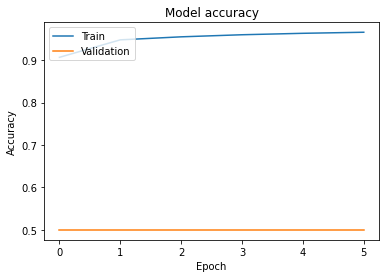

In [16]:
import matplotlib.pyplot as plt
#accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

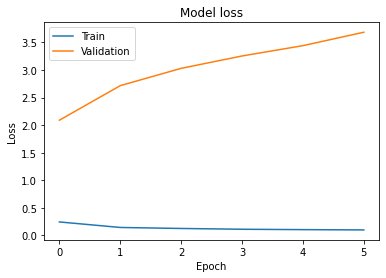

In [17]:
#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
for layer in base_model.layers[:-5]:
    base_model.trainable = False
    

resnet_model = tf.keras.Sequential([
                                    base_model,
                                    layers.GlobalAveragePooling2D(),
                                    layers.Dense(1, activation="sigmoid")
])
resnet_model.load_weights('1_all_nontrainable.h5')

resnet_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(lr= 0.001),
    metrics = ["accuracy"]
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)

history = resnet_model.fit(train_data_1,
                 epochs = 10,
                 steps_per_epoch= len(train_data_1),
                 validation_data = val_data,
                 validation_steps = len(val_data),
                 callbacks = [early_stopping_cb]
                 )

resnet_model.save_weights('1_5_layer_nontrainable.h5')


Train for 157 steps, validate for 1 steps
Epoch 1/10
157/157 [==============================] - 1105s 7s/step - loss: 0.0961 - accuracy: 0.9645 - val_loss: 3.9498 - val_accuracy: 0.5000
Epoch 2/10
157/157 [==============================] - 1099s 7s/step - loss: 0.0929 - accuracy: 0.9669 - val_loss: 4.1640 - val_accuracy: 0.5000
Epoch 3/10


In [ ]:
resnet_model_evaluation = resnet_model.evaluate(test_data)
print(f"Resnet Model Accuracy: {resnet_model_evaluation[1]*100: 0.2f}%")

In [ ]:

#accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()